/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17034.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17035.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17036.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17037.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17038.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17039.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17040.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17041.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17042.out
/home/sthomas/projects/a4md/examples/sequential_in_transit_plumed_global_module/slurm-17043.out
/home/sthomas/projects/a4md/examples/seq

/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure i

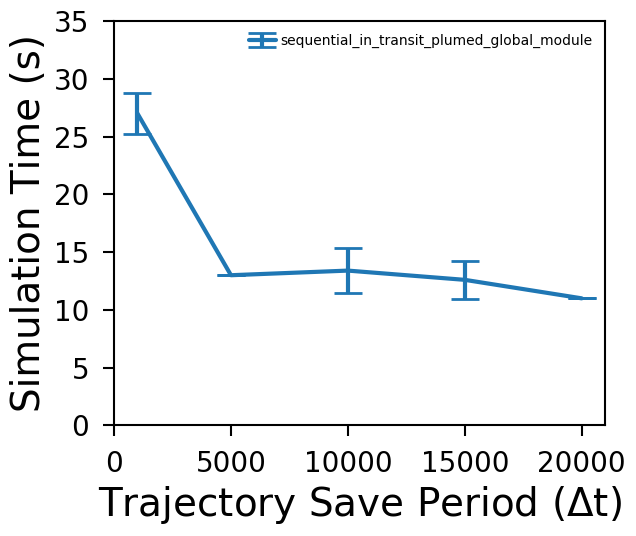

In [22]:
import numpy as np
import os
from glob import iglob
from collections import defaultdict
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

def timestamp_to_seconds(t):
    return sum(float(n) * m for n, m in zip(reversed(t), (1, 60, 3600)))


# This will return absolute paths
paths = ['sequential','sequential_in_transit_plumed_global_module']
for path in paths:
    total_times = defaultdict(list)
    sim_time_dict = defaultdict(list)
    log_files = [os.path.abspath(f) for f in iglob('{}/slurm*'.format(path), recursive=True)]
    for log_file in log_files:
        total_time=None
        dump_interval = None
        sim_times=[]
        with open(log_file) as fp:
            line = fp.readline()
            #print(line)
            while line:
                if 'DUMP_INTERVAL' in line:
                    values = line.split(':')
                    if float(values[1]) >500:
                        dump_interval = float(values[1])
                if 'Total wall time' in line:
                    values = line.split(':')
                    sim_time = float(timestamp_to_seconds(values[1:]))
                    sim_times.append(sim_time)
                    #print('Found sim time',sim_time)
                if 'SIM_TIME' in line:
                    values = line.split(':')
                    total_time = float(values[1])
                    break
                line = fp.readline()
            if total_time is not None and dump_interval is not None:
                total_times[dump_interval].append(total_time)
        if len(sim_times)>0 and dump_interval is not None:
            #print(log_file)
            sim_time_dict[dump_interval].append(sim_times[-1])
        else:
            #print('Could not find sim time in ',log_file)
            continue
    print(sim_time_dict)
    mean_tts = [np.mean(sim_time_vals) for dump_interval, sim_time_vals in sim_time_dict.items()]
    std_tts = [stats.sem(sim_time_vals) for dump_interval, sim_time_vals in sim_time_dict.items()]
    dump_intervals = sim_time_dict.keys()
    plt.errorbar(dump_intervals,mean_tts,std_tts, 
                 #fmt='o', 
                 #ecolor='g',
                 capsize=10, 
                 #elinewidth=3,
                 capthick=2,
                label=path)
plt.xlabel("Trajectory Save Period ($\Delta$t)")
plt.ylabel("Simulation Time (s)")
plt.legend(fontsize=10)
plt.ylim(0,35)
plt.xlim(0,21000)
plt.savefig('figure_sim_time.png', transparent=True)
plt.show()